✅ Dataset Loaded Successfully!
Shape: (1988, 40)
   id  LOC_BLANK  BRANCH_COUNT  CALL_PAIRS  LOC_CODE_AND_COMMENT  \
0   1          8            17          12                     1   
1   2          2             5           3                     1   
2   3         11             7           2                     0   
3   4          0             5           1                     0   
4   5          0             1           2                     0   

   LOC_COMMENTS  CONDITION_COUNT  CYCLOMATIC_COMPLEXITY  CYCLOMATIC_DENSITY  \
0            11               30                      9                0.16   
1             0                8                      3                0.19   
2           117               12                      4                0.08   
3             0                8                      3                0.60   
4             2                0                      1                0.20   

   DECISION_COUNT  ...  NODE_COUNT  NORMALIZED_CYLOMATIC_COMPLEXITY

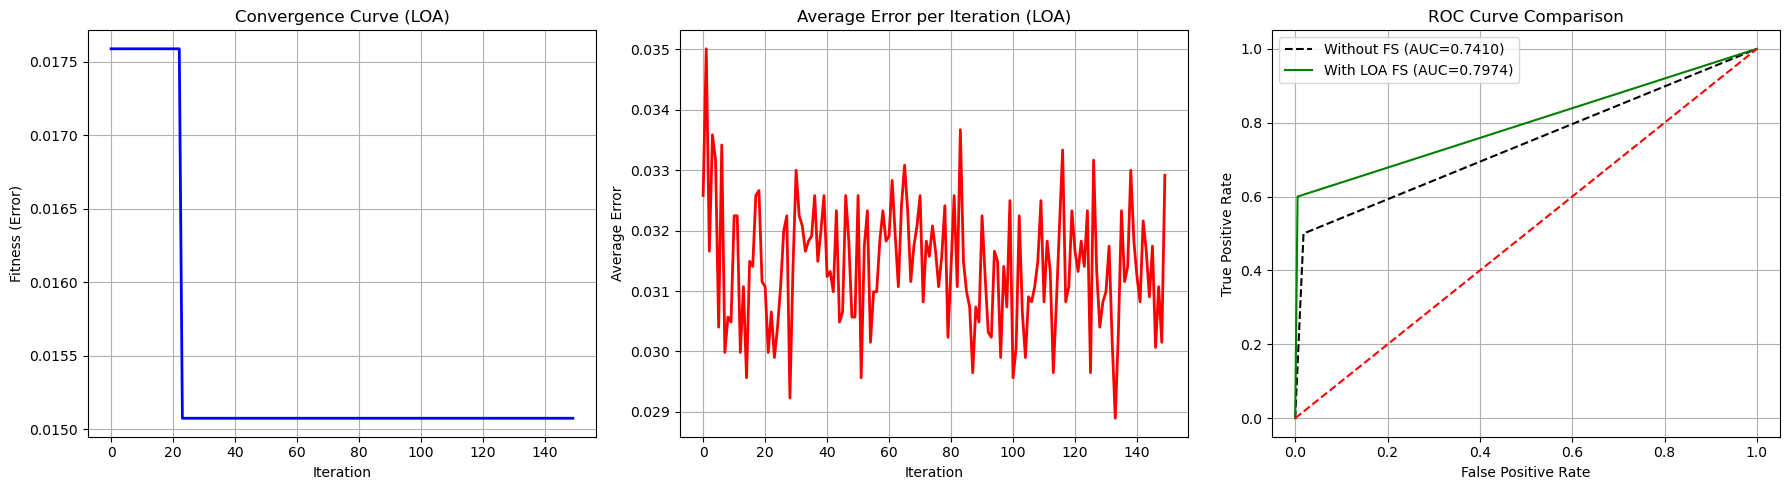

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# =================== Load Dataset ===================
# Update this path to your dataset location on your local machine
data = pd.read_csv(r"C:\Users\KIIT\OneDrive\Desktop\project\mc1_csv.csv")
print("✅ Dataset Loaded Successfully!")
print(f"Shape: {data.shape}")
print(data.head())

# Separate features and target
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Drop 'id' column if present
if 'id' in X.columns:
    X.drop('id', axis=1, inplace=True)

# Normalize features
scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Dim = X_train.shape[1]

# Encode target labels for metric calculations and probabilities
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
pos_label_index = le.transform(['Y'])[0]

# =================== Baseline Decision Tree ===================
clf_base = DecisionTreeClassifier(random_state=42)
clf_base.fit(X_train, y_train)
pred_base = clf_base.predict(X_test)
prob_base = clf_base.predict_proba(X_test)[:, pos_label_index]

# Metrics
acc_base = accuracy_score(y_test, pred_base)
prec_base = precision_score(y_test, pred_base, pos_label='Y')
rec_base = recall_score(y_test, pred_base, pos_label='Y')
f1_base = f1_score(y_test, pred_base, pos_label='Y')
auc_base = roc_auc_score(y_test_encoded, prob_base)

print("\n📊 Baseline Decision Tree (All Features):")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 Score : {f1_base:.4f}")
print(f"AUC      : {auc_base:.4f}")

# =================== Lyrebird Optimization Algorithm (LOA) ===================
def fitness_function(features):
    """Fitness based on Decision Tree classification error"""
    selected = np.where(features == 1)[0]
    if len(selected) == 0:
        return 1.0  # worst if no feature selected
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train.iloc[:, selected], y_train)
    pred = clf.predict(X_test.iloc[:, selected])
    acc = accuracy_score(y_test, pred)
    return 1 - acc  # minimize error

def LOA_feature_selection(Dim, MaxIter=150, N=30):
    X_pop = np.random.randint(0, 2, (N, Dim))
    Fitness = np.full(N, np.inf)
    alpha, beta, gamma = 0.5, 0.8, 0.9
    Best_FF = np.inf
    Best_P = np.zeros(Dim)
    Conv_curve = np.zeros(MaxIter)
    Avg_error_curve = np.zeros(MaxIter)

    print("\n🚀 LOA Optimization Started...")
    for t in range(MaxIter):
        errors = []
        for i in range(N):
            A = alpha * np.random.uniform(-1, 1, Dim)
            B = beta * np.random.uniform(0, 1, Dim)
            C = gamma * np.random.uniform(0, 1)

            new_pos = X_pop[i] + A * (Best_P - B * X_pop[i]) + C * np.random.randn(Dim)
            new_pos = 1 / (1 + np.exp(-new_pos))  # sigmoid
            new_pos = np.where(new_pos > 0.5, 1, 0)

            new_fit = fitness_function(new_pos)
            errors.append(new_fit)

            if new_fit < Fitness[i]:
                X_pop[i] = new_pos.copy()
                Fitness[i] = new_fit

            if new_fit < Best_FF:
                Best_FF = new_fit
                Best_P = new_pos.copy()

        Conv_curve[t] = Best_FF
        Avg_error_curve[t] = np.mean(errors)

        if t % 20 == 0 or t == MaxIter-1:
            print(f"Iteration {t+1}/{MaxIter} -> Best Fitness: {Best_FF:.4f}")

    print("✅ LOA Optimization Completed!")
    return Best_P, Best_FF, Conv_curve, Avg_error_curve

# =================== Run LOA ===================
Best_features, Best_error, Conv_curve, Avg_error_curve = LOA_feature_selection(Dim=Dim, MaxIter=150, N=30)
selected_idx = np.where(Best_features == 1)[0]

print(f"\n🎯 Selected {len(selected_idx)} features out of {Dim}:")
print(list(X_train.columns[selected_idx]))

# =================== Decision Tree with Selected Features ===================
clf_loa = DecisionTreeClassifier(random_state=42)
clf_loa.fit(X_train.iloc[:, selected_idx], y_train)
pred_loa = clf_loa.predict(X_test.iloc[:, selected_idx])
prob_loa = clf_loa.predict_proba(X_test.iloc[:, selected_idx])[:, pos_label_index]

# Metrics
acc_loa = accuracy_score(y_test, pred_loa)
prec_loa = precision_score(y_test, pred_loa, pos_label='Y')
rec_loa = recall_score(y_test, pred_loa, pos_label='Y')
f1_loa = f1_score(y_test, pred_loa, pos_label='Y')
auc_loa = roc_auc_score(y_test_encoded, prob_loa)

print("\n📊 Decision Tree + LOA Feature Selection:")
print(f"Accuracy : {acc_loa:.4f}")
print(f"Precision: {prec_loa:.4f}")
print(f"Recall   : {rec_loa:.4f}")
print(f"F1 Score : {f1_loa:.4f}")
print(f"AUC      : {auc_loa:.4f}")

# =================== Comparison Table ===================
results = pd.DataFrame({
    "Model": ["Decision Tree (All Features)", "Decision Tree + LOA (Selected Features)"],
    "Accuracy": [acc_base, acc_loa],
    "Precision": [prec_base, prec_loa],
    "Recall": [rec_base, rec_loa],
    "F1-Score": [f1_base, f1_loa],
    "AUC": [auc_base, auc_loa]
})
print("\n📈 Comparison of Decision Tree With & Without LOA:\n")
print(results.to_string(index=False))

# =================== Visualization ===================
plt.figure(figsize=(18,5))

plt.subplot(1, 3, 1)
plt.plot(Conv_curve, 'b-', linewidth=2)
plt.title("Convergence Curve (LOA)")
plt.xlabel("Iteration")
plt.ylabel("Fitness (Error)")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(Avg_error_curve, 'r-', linewidth=2)
plt.title("Average Error per Iteration (LOA)")
plt.xlabel("Iteration")
plt.ylabel("Average Error")
plt.grid(True)

fpr_base, tpr_base, _ = roc_curve(y_test, prob_base, pos_label='Y')
fpr_loa, tpr_loa, _ = roc_curve(y_test, prob_loa, pos_label='Y')
plt.subplot(1, 3, 3)
plt.plot(fpr_base, tpr_base, 'k--', label=f'Without FS (AUC={auc_base:.4f})')
plt.plot(fpr_loa, tpr_loa, 'g-', label=f'With LOA FS (AUC={auc_loa:.4f})')
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
